# Process boundary files

*This script was used to extract features within the study area from a large zipped dataset. The zipped data were then deleted to conserve storage space.*

## Scope

- Unzip and read in boundary shapefiles:
    - National Forest Administrative Boundaries polygon shapefile
    - United States political boundaries polygon shapefile
- Convert shapefiles to GeoDataFrames
- Extract desired features:
    - From National Forests polygon layer, extract Malheur National Forest boundary polygon
    - From United States state boundaries, extract Oregon boundary polygon
- Export extracted features as GeoJSONs

# Import necessary packages

In [17]:
import geopandas as gpd
import fiona
import os
import zipfile
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_origin
import pandas as pd

In [18]:
# Define paths to zipped folders
state_bounds_zip_path = r"boundary_polygons/tl_2024_us_state.zip"
forest_bounds_zip_path = r"boundary_polygons/Forest_Administrative_Boundaries_(Feature_Layer).zip"

output_folder = r"boundary_polygons"

In [19]:
# Make directory for boundary GeoJSONs
# Define the new directory path
boundary_shapefile_path = os.path.join(output_folder, "boundary_shps")
boundary_geojsons_path = os.path.join(output_folder, "boundary_geoJSONs")

# Create the directory if it doesn't already exist
os.makedirs(boundary_shapefile_path, exist_ok = True)
os.makedirs(boundary_geojsons_path, exist_ok = True)

In [21]:
# Define unzip to output location function
def unzip_folder(zip_path, extract_to): 
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to: {boundary_shapefile_path}")

unzip_folder(state_bounds_zip_path, boundary_shapefile_path)
unzip_folder(forest_bounds_zip_path, boundary_shapefile_path)

Extracted to: boundary_polygons/boundary_shps
Extracted to: boundary_polygons/boundary_shps


In [9]:
# Read in shapefiles as GeoDataFrames
states_gdf = gpd.read_file("tl_2024_us_state.shp")
forests_gdf = gpd.read_file("Forest_Administrative_Boundaries_(Feature_Layer).shp")

## Forests

In [22]:
forests_gdf.head()

,OBJECTID,ADMINFORES,REGION,FORESTNUMB,FORESTORGC,FORESTNAME,GIS_ACRES,SHAPELEN,SHAPEAREA,geometry
0,206935,99010200010343,01,02,0102,Beaverhead-Deerlodge National Forest,3614441.557,38.630359,1.687597,"MULTIPOLYGON (((-12589547.709 5807709.533, -12..."
1,206936,99010300010343,01,03,0103,Bitterroot National Forest,1664505.633,12.217248,0.781396,"MULTIPOLYGON (((-12716253.349 5785096.466, -12..."
2,206937,99010400010343,01,04,0104,Idaho Panhandle National Forests,2943321.271,31.729553,1.433425,"MULTIPOLYGON (((-12989704.935 6084863.79, -129..."
3,206938,99011000010343,01,10,0110,Flathead National Forest,2651682.450,19.359223,1.294017,"MULTIPOLYGON (((-12707535.143 6179716.225, -12..."
4,206939,99011100010343,01,11,0111,Custer Gallatin National Forest,3412189.636,25.627171,1.585256,"MULTIPOLYGON (((-12244266.412 5727747.148, -12..."


GeoJSON file saved at: boundary_polygons/boundary_geoJSONs/state_bounds_OR_WA.geojson


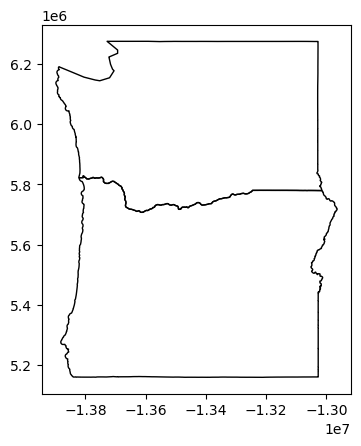

In [23]:
# Reproject states_gdf into EPSG 3857 Web Mercator
states_gdf = states_gdf.to_crs(epsg = 3857)

# Create new gdf containing bounds of WA and OR only
state_bounds_OR_WA = states_gdf.loc[(states_gdf["NAME"] == "Washington") | (states_gdf["NAME"] == "Oregon")]
state_bounds_OR_WA.plot(facecolor = "None")

# Define the output file path
output_file = os.path.join(boundary_geojsons_path, "state_bounds_OR_WA.geojson")

# Export to GeoJSON
state_bounds_OR_WA.to_file(output_file, driver = "GeoJSON")

print(f"GeoJSON file saved at: {output_file}")

## Malheur National Forest boundary

In [12]:
pnw_forests = gpd.clip(forests_gdf, state_bounds_OR_WA) # Clip forests to WA and OR state bounds

In [13]:
pnw_forest_count = len(pnw_forests)
print(f"There are {pnw_forest_count} National Forests in Washington and Oregon.")

There are 23 National Forests in Washington and Oregon.


In [14]:
malheur_bounds = pnw_forests.loc[pnw_forests["FORESTNAME"].str.contains("Malheur", case = False, na = False)] # Return all records where 'FORESTNAME' includes substring 'Malheur', case agnostic
malheur_bounds.head() 

,OBJECTID,ADMINFORES,REGION,FORESTNUMB,FORESTORGC,FORESTNAME,GIS_ACRES,SHAPELEN,SHAPEAREA,geometry
65,207000,99060400010343,06,04,0604,Malheur National Forest,1786533.257,14.733412,0.813817,"MULTIPOLYGON (((-13217630.165 5552264.314, -13..."


<Axes: >

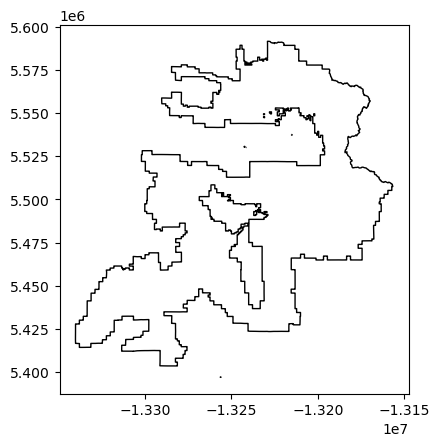

In [15]:
malheur_bounds.plot(facecolor = "None")

In [16]:
# Define the output file path
pnw_forests_output_file = os.path.join(boundary_geojsons_path, "pnw_forest_bounds.geojson")

# Export to GeoJSON
pnw_forests.to_file(pnw_forests_output_file, driver = "GeoJSON")

print(f"GeoJSON file saved at: {pnw_forests_output_file}")

# Define the output file path
mnf_output_file = os.path.join(boundary_geojsons_path, "malheur_bounds.geojson")

# Export to GeoJSON
malheur_bounds.to_file(mnf_output_file, driver = "GeoJSON")

print(f"GeoJSON file saved at: {mnf_output_file}")

GeoJSON file saved at: boundary_geoJSONs/pnw_forest_bounds.geojson
GeoJSON file saved at: boundary_geoJSONs/malheur_bounds.geojson
